In [7]:
import numpy as np
import tensorflow as tf
tf.compat.v1.logging.set_verbosity('ERROR')
from tensorflow import keras
from tensorflow.keras.layers import Dense, Input, LeakyReLU
from tensorflow.keras.models import Model
from collections import defaultdict, deque
from tqdm import tqdm
import matplotlib.pyplot as plt
from Environment_one_hot import *

In [8]:
LENGTH = 6000
WIDTH = 5000
DIVISION = 50
K = 6
NUM_BASE_STATIONS = 7

env = Environment(LENGTH, WIDTH, DIVISION, 1, 0, K)

Location and directions of cells are: 
{1: [0, 0, 0], 2: [0, 0, 1], 3: [0, 0, 2], 4: [1500.0, 0, 0], 5: [1500.0, 0, 1], 6: [1500.0, 0, 2], 7: [750.0, 1250.0, 0], 8: [750.0, 1250.0, 1], 9: [750.0, 1250.0, 2], 10: [-750.0, 1250.0, 0], 11: [-750.0, 1250.0, 1], 12: [-750.0, 1250.0, 2], 13: [-1500.0, 0, 0], 14: [-1500.0, 0, 1], 15: [-1500.0, 0, 2], 16: [-750.0, -1250.0, 0], 17: [-750.0, -1250.0, 1], 18: [-750.0, -1250.0, 2], 19: [750.0, -1250.0, 0], 20: [750.0, -1250.0, 1], 21: [750.0, -1250.0, 2]} 
 

Strongest cells for sector (0, 0)
[[5.0, -70.7964230979452], [13.0, -71.5106397517581], [20.0, -79.04722890306279], [10.0, -79.61740184525891], [16.0, -79.68034878579805], [9.0, -83.52127127291698]]


Strongest cells for sector (0, 100)
[[5.0, -73.4585612765066], [13.0, -75.04673610635857], [2.0, -77.97616777976559], [20.0, -85.37770543483998], [10.0, -85.90067890732699], [17.0, -87.32367170009124]]


Strongest cells for sector (50, 0)
[[5.0, -70.04322533155998], [20.0, -76.04138621527922], [

In [9]:
class Agent:
    def __init__(self, k, NUM_BASE_STATIONS):
        self.k = k
        cells = 3*NUM_BASE_STATIONS
        num_inputs = 2 + 8 + cells
        # Model
        #--------------------------------------------------------------------
        input_A = Input(shape = num_inputs) #(x, y, direction, current_serving_cell_one_hot_encoded)
        x = Dense(32)(input_A)
        x = LeakyReLU()(x)
        x = Dense(64)(x)
        x = LeakyReLU()(x)
#         x = Dense(32)(x)
#         x = LeakyReLU()(x)
        x = Dense(self.k)(x)
        
        self.model = Model(inputs = input_A, outputs = x)
        print(self.model.summary())
        #--------------------------------------------------------------------
        
        self.target_model = tf.keras.models.clone_model(self.model)
        self.target_model.set_weights(self.model.get_weights())
        
        self.loss_fn = tf.keras.losses.mean_squared_error
        self.optimizer = tf.keras.optimizers.Adam(lr = 0.0005)
        
        self.batch_size = 1024
        self.epsilon = 1
        self.gamma = 0.3
        self.replay_buffer_size = 10240
        
        #Replay Buffers
        self.action_history = deque(maxlen = self.replay_buffer_size)
        self.state_history = deque(maxlen = self.replay_buffer_size)
        self.next_state_history = deque(maxlen = self.replay_buffer_size)
        self.rewards_history = deque(maxlen = self.replay_buffer_size)
        self.done_history = deque(maxlen = self.replay_buffer_size)

        
    def play_one_step(self, state, route, dest, Wrsrp, Who, baseline = False):
        if not baseline:
            action = self.exp_policy(state)
        else:
            action = 0
            
        next_state, reward, done, change = env.step(state, route, action, dest)
        next_state = list(next_state)
        reward*=Wrsrp
        reward-=change*Who
        
        self.append_replay_buffer(state, action, next_state, reward, done)
        return next_state, reward, done, change
    
    def exp_policy(self, state):
        if np.random.rand()<self.epsilon:
            return np.random.randint(self.k)
        else:
            normalised_state = self.normalise_inputs(np.array(state)[np.newaxis])
            Q_values = self.model(normalised_state)
            return np.argmax(Q_values[0])
        
    def append_replay_buffer(self, state, action, next_state, reward, done):
        self.state_history.append(state)
        self.action_history.append(action)
        self.next_state_history.append(next_state)
        self.rewards_history.append(reward)
        self.done_history.append(done)
        
    def sample_experience(self):
        indices = np.random.randint(len(self.state_history), size = self.batch_size)
        
        states = np.array([self.state_history[i] for i in indices])
        actions = np.array([self.action_history[i] for i in indices])
        next_states = np.array([self.next_state_history[i] for i in indices])
        rewards = np.array([self.rewards_history[i] for i in indices])
        dones = np.array([self.done_history[i] for i in indices])
        
        return states, actions, next_states, rewards, dones
        
    
    def training_step(self, num_training_episode):
        for _ in range(num_training_episode):
            states, actions, next_states, rewards, dones = self.sample_experience()

            states = self.normalise_inputs(states)
            next_states = self.normalise_inputs(next_states)

            next_Q_values = self.target_model(next_states)
            max_next_Q_values = np.max(next_Q_values, axis= 1)

            target_Q_values = rewards + (1-dones)*self.gamma*max_next_Q_values
            mask = tf.one_hot(actions, self.k)

            with tf.GradientTape() as tape:
                all_Q_values = self.model(states)
                Q_values = tf.reduce_sum(all_Q_values*mask, axis = 1, keepdims = True)
                loss = tf.reduce_mean(self.loss_fn(target_Q_values, Q_values))

            grads = tape.gradient(loss, self.model.trainable_variables)
            self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
        
        
    def normalise_inputs(self, states):
        '''Normalising the inputs to the NN'''
        states = states.astype('float')
        states[:,0]/=(LENGTH/2)
        states[:,1]/=(WIDTH/2)
        states = tf.convert_to_tensor(states)
        
        return states
        
        
        

In [10]:
agent_0 = Agent(6, NUM_BASE_STATIONS)

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 31)]              0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1024      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                2112      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 390       
Total params: 3,526
Trainable params: 3,526
Non-trainable params: 0
____________________________________________________

  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]

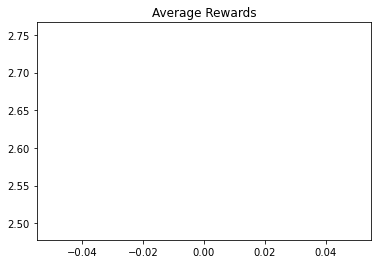

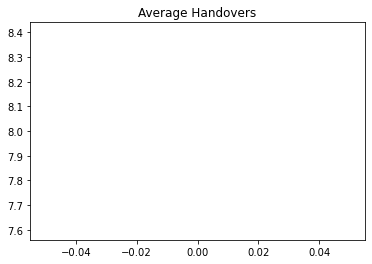

 10%|███████▋                                                                     | 1000/10000 [00:49<07:23, 20.27it/s]

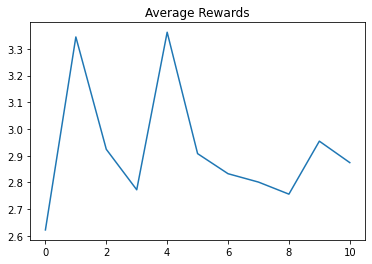

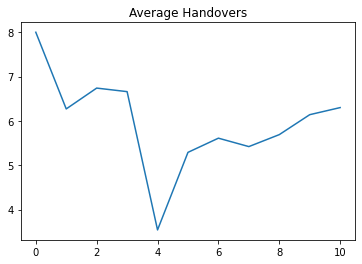

 10%|███████▋                                                                     | 1005/10000 [00:50<11:41, 12.82it/s]

Saved new weights for reward of 2.8742439925724925


 11%|████████▍                                                                    | 1103/10000 [00:55<07:34, 19.59it/s]

Saved new weights for reward of 2.882154169668951


 13%|██████████                                                                   | 1303/10000 [01:05<07:19, 19.77it/s]

Saved new weights for reward of 2.894308799803211


 14%|██████████▊                                                                  | 1403/10000 [01:10<07:12, 19.86it/s]

Saved new weights for reward of 2.999165190812885


 20%|███████████████▍                                                             | 2000/10000 [01:35<05:33, 23.95it/s]

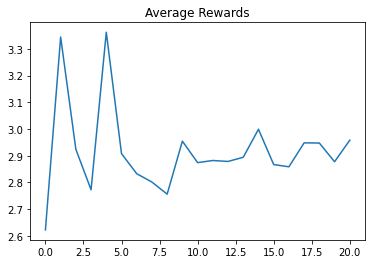

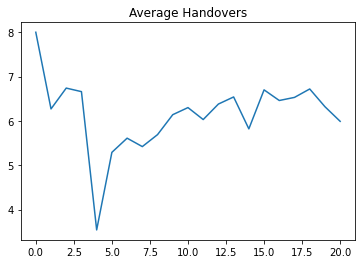

 22%|████████████████▉                                                            | 2204/10000 [01:43<05:36, 23.17it/s]

Saved new weights for reward of 3.0283762437460915


 24%|██████████████████▌                                                          | 2405/10000 [01:52<05:25, 23.34it/s]

Saved new weights for reward of 3.101170678585833


 27%|████████████████████▊                                                        | 2705/10000 [02:04<05:10, 23.47it/s]

Saved new weights for reward of 3.1440640291172444


 30%|███████████████████████                                                      | 2999/10000 [02:17<04:46, 24.42it/s]

Saved new weights for reward of 3.1635598544147308


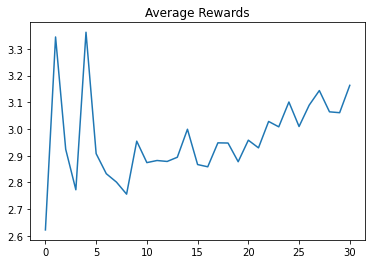

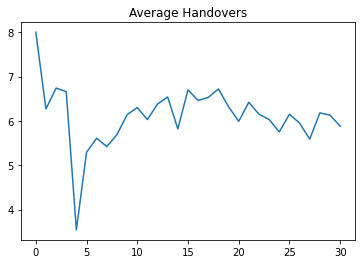

 37%|████████████████████████████▌                                                | 3704/10000 [02:46<04:07, 25.44it/s]

Saved new weights for reward of 3.2135081108141508


 40%|██████████████████████████████▊                                              | 3998/10000 [02:58<03:55, 25.47it/s]

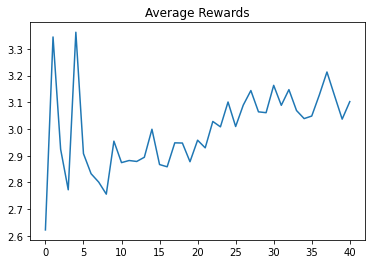

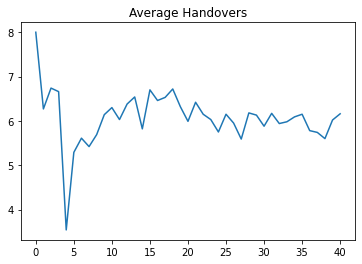

 50%|██████████████████████████████████████▌                                      | 5000/10000 [03:36<03:09, 26.44it/s]

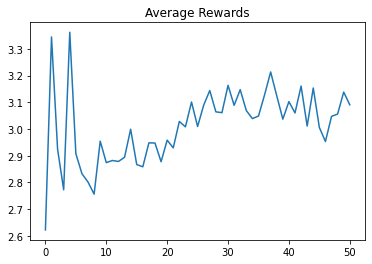

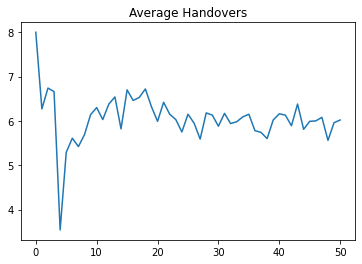

 60%|██████████████████████████████████████████████▏                              | 5999/10000 [04:13<02:25, 27.50it/s]

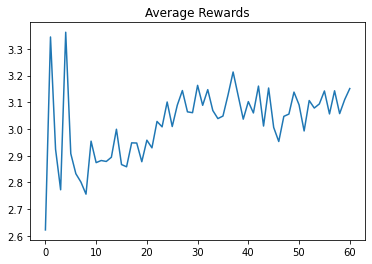

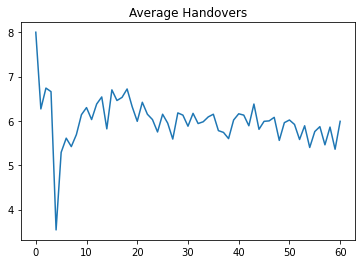

 70%|█████████████████████████████████████████████████████▉                       | 6998/10000 [04:51<01:52, 26.79it/s]

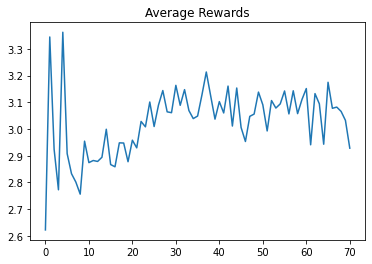

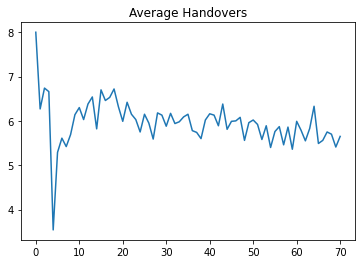

 80%|█████████████████████████████████████████████████████████████▌               | 8000/10000 [05:31<01:17, 25.73it/s]

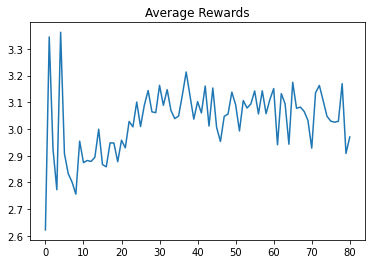

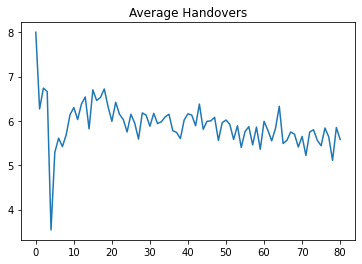

 87%|███████████████████████████████████████████████████████████████████          | 8705/10000 [05:59<01:00, 21.51it/s]

Saved new weights for reward of 3.290334079100825


 90%|█████████████████████████████████████████████████████████████████████▎       | 8999/10000 [06:11<00:42, 23.80it/s]

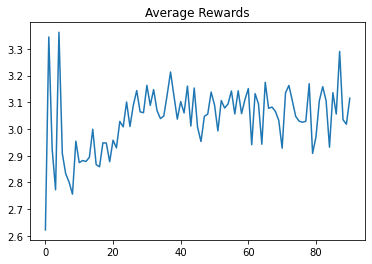

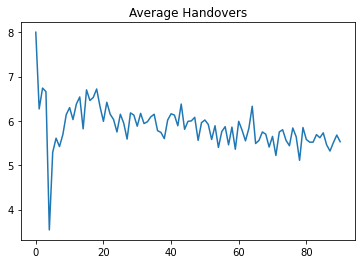

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [06:55<00:00, 24.06it/s]


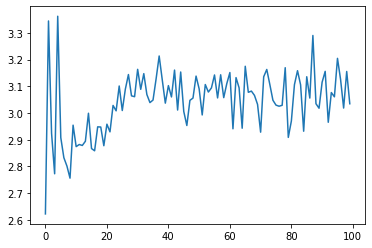

3.0347202529896937


In [11]:
agent = agent_0
Wrsrp = 1
Who = 0
last_r = []
rewards = []
hos = []
last_r_hos = []
r = 100
num_training_episode = 1 #training steps per episode
target_model_update = 10
max_reward = float('-inf')
path = 'agent_0.h5'

for episode in tqdm(range(10000)):
    src,dest = env.give_src_dest()
    src = (3000,2000)
    dest = (3000, 1500)
    route = env.compute_route(src, dest)
    state = route.popleft()
    depth = 3*NUM_BASE_STATIONS
    one_hot_cell = make_one_hot(env.sector_cells[src][0][0], depth)
    one_hot_direction = make_one_hot(state[-1]+1, 8)
    state = state[:-1]
    state.extend(one_hot_direction)
    state.extend(one_hot_cell) #Setting strongest cell as the initial serving cell (one_hot)
    done = 0
    total_reward = 0
    action = 0
    num_hos = 0
    
    while done==0:
        next_state, reward, done, change = agent.play_one_step(state, route, dest, Wrsrp, Who)
        total_reward+=reward
        if change:
            num_hos+=1
        state = next_state
        
    
    last_r_hos.append(num_hos)
    last_r.append(total_reward)
    
    if not episode%r:
        rewards.append(np.average(np.array(last_r)))
        hos.append(np.mean(last_r_hos))
        last_r = []
        last_r_hos = []
        
    if episode>50:
        agent.training_step(num_training_episode)
        
    if rewards[-1]>max_reward and episode>1000:
        max_reward = rewards[-1]
        agent.model.save_weights(path)
        print(f'Saved new weights for reward of {max_reward}')

    
    if episode%target_model_update==0:
        agent.target_model.set_weights(agent.model.get_weights())
    
    if episode%100==0:
        agent.epsilon*=0.99
        agent.epsilon = min(agent.epsilon, 0.05)
            
    if episode%1000==0:
        plt.plot(rewards)
        plt.title('Average Rewards')
        plt.show()
        plt.plot(hos)
        plt.title('Average Handovers')
        plt.show()
        
plt.plot(rewards)
plt.show()
print(rewards[-1])

In [12]:
agent.model.load_weights(path)
hos = []
rewards = []
agent.epsilon = 0
for episode in tqdm(range(100)):
    src,dest = env.give_src_dest()
    src = (3000,2000)
    dest = (3000, 1500)
    route = env.compute_route(src, dest)
    state = route.popleft()
    depth = 3*NUM_BASE_STATIONS
    one_hot_cell = make_one_hot(env.sector_cells[src][0][0], depth)
    one_hot_direction = make_one_hot(state[-1]+1, 8)
    state = state[:-1]
    state.extend(one_hot_direction)
    state.extend(one_hot_cell) #Setting strongest cell as the initial serving cell (one_hot)
    done = 0
    total_reward = 0
    num_hos = 0
    
    while done==0:
        next_state, reward, done, change = agent.play_one_step(state, route, dest, Wrsrp, Who)
        total_reward+=reward
        if change:
            num_hos +=1
        state = next_state
        
    rewards.append(total_reward)
    hos.append(num_hos)

agent.mean_reward = np.mean(rewards) 
agent.mean_hos = np.mean(hos)

print(agent.mean_reward)
print(agent.mean_hos)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 90.35it/s]

3.5277562046015736
3.0


In [7]:
agent_19 = Agent(6, NUM_BASE_STATIONS)
#lr = 0.005, 0.001, batch_size = 256, same for agent_0
#epsilon = 1

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 31)]              0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1024      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                2112      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 390       
Total params: 3,526
Trainable params: 3,526
Non-trainable params: 0
____________________________________________________

  0%|                                                                                         | 0/2000 [00:00<?, ?it/s]

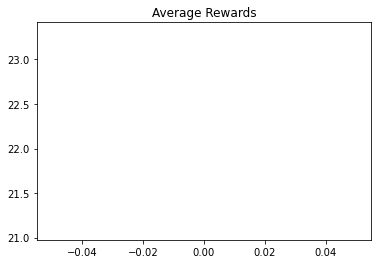

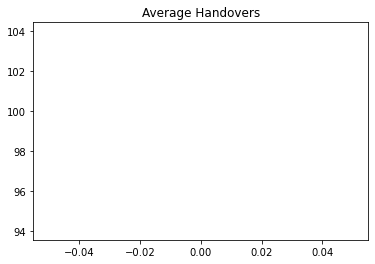

 50%|███████████████████████████████████████                                       | 1000/2000 [02:07<02:02,  8.17it/s]

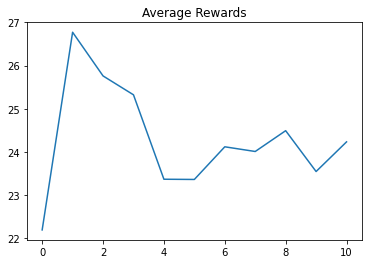

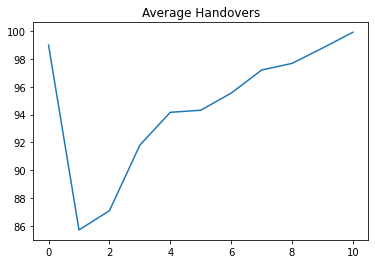

 50%|███████████████████████████████████████                                       | 1003/2000 [02:08<02:40,  6.20it/s]

Saved new weights for reward of 24.234234046587517


 55%|██████████████████████████████████████████▉                                   | 1102/2000 [02:20<01:55,  7.79it/s]

Saved new weights for reward of 25.079000292613173


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [04:14<00:00,  7.87it/s]


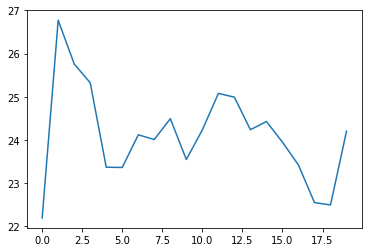

24.205133316155596


In [8]:
agent = agent_19
Wrsrp = 1
Who = 1/9
last_r = []
rewards = []
hos = []
last_r_hos = []
r = 100
num_training_episode = 1 #training steps per episode
target_model_update = 100
max_reward = float('-inf')
path = 'agent_19.h5'

for episode in tqdm(range(2000)):
    src,dest = env.give_src_dest()
    src = (-3000,-2000)
    dest = (3000, 2000)
    route = env.compute_route(src, dest)
    state = route.popleft()
    depth = 3*NUM_BASE_STATIONS
    one_hot_cell = make_one_hot(env.sector_cells[src][0][0], depth)
    one_hot_direction = make_one_hot(state[-1]+1, 8)
    state = state[:-1]
    state.extend(one_hot_direction)
    state.extend(one_hot_cell) #Setting strongest cell as the initial serving cell (one_hot)
    done = 0
    total_reward = 0
    action = 0
    num_hos = 0

    
    while done==0:
        next_state, reward, done, change = agent.play_one_step(state, route, dest, Wrsrp, Who)
        total_reward+=reward
        state = next_state
        if change:
            num_hos+=1
    
    last_r_hos.append(num_hos)
    last_r.append(total_reward)
    
    if not episode%r:
        rewards.append(np.average(np.array(last_r)))
        hos.append(np.mean(last_r_hos))
        last_r = []
        last_r_hos = []
        
    if episode>50:
        agent.training_step(num_training_episode)
        
    if rewards[-1]>max_reward and episode>1000:
        max_reward = rewards[-1]
        agent.model.save_weights(path)
        print(f'Saved new weights for reward of {max_reward}')
            
    
    if episode%target_model_update==0:
        agent.target_model.set_weights(agent.model.get_weights())
    
    if episode%100==0:
        agent.epsilon*=0.99
        agent.epsilon = min(agent.epsilon, 0.05)
            
    if episode%1000==0:
        plt.plot(rewards)
        plt.title('Average Rewards')
        plt.show()
        plt.plot(hos)
        plt.title('Average Handovers')
        plt.show()
        
plt.plot(rewards)
plt.show()
print(rewards[-1])

In [9]:
agent.model.load_weights(path)
hos = []
rewards = []
agent.epsilon = 0
for episode in tqdm(range(100)):
    src,dest = env.give_src_dest()
    src = (-3000,-2000)
    dest = (3000, 2000)
    route = env.compute_route(src, dest)
    state = route.popleft()
    depth = 3*NUM_BASE_STATIONS
    one_hot_cell = make_one_hot(env.sector_cells[src][0][0], depth)
    one_hot_direction = make_one_hot(state[-1]+1, 8)
    state = state[:-1]
    state.extend(one_hot_direction)
    state.extend(one_hot_cell) #Setting strongest cell as the initial serving cell (one_hot)
    done = 0
    total_reward = 0
    num_hos = 0
    
    while done==0:
        next_state, reward, done, change = agent.play_one_step(state, route, dest, Wrsrp, Who)
        total_reward+=reward
        state = next_state
        if change:
            num_hos +=1
    rewards.append(total_reward)
    hos.append(num_hos)

agent.mean_reward = np.mean(rewards) 
agent.mean_hos = np.mean(hos)

print(agent.mean_reward)
print(agent.mean_hos)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.68it/s]

23.104455570221095
109.0


In [10]:
agent_1_1 = Agent(6, NUM_BASE_STATIONS)
#lr = 0.0005, batch_size = 1024

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 31)]              0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                1024      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                2112      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 6)                 390       
Total params: 3,526
Trainable params: 3,526
Non-trainable params: 0
____________________________________________________

  0%|                                                                                         | 0/2000 [00:00<?, ?it/s]

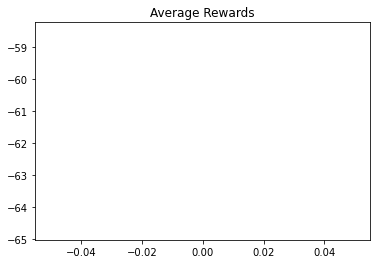

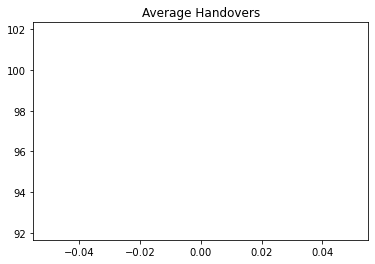

 50%|███████████████████████████████████████                                       | 1000/2000 [02:02<02:04,  8.04it/s]

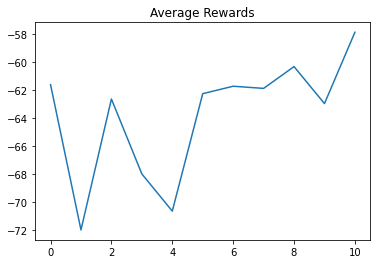

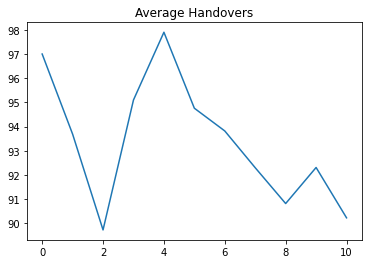

 50%|███████████████████████████████████████                                       | 1003/2000 [02:03<02:44,  6.07it/s]

Saved new weights for reward of -57.883080475885045


 60%|██████████████████████████████████████████████▉                               | 1202/2000 [02:27<01:37,  8.15it/s]

Saved new weights for reward of -57.87890034360788


 65%|██████████████████████████████████████████████████▊                           | 1302/2000 [02:40<01:26,  8.11it/s]

Saved new weights for reward of -56.82984150191613


 75%|██████████████████████████████████████████████████████████▌                   | 1502/2000 [03:08<01:01,  8.07it/s]

Saved new weights for reward of -56.67487283859875


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [04:11<00:00,  7.96it/s]


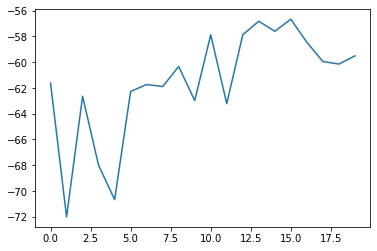

-59.5186177413802


In [11]:
agent = agent_1_1
Wrsrp = 1
Who = 1
last_r = []
rewards = []
hos = []
last_r_hos = []
r = 100
num_training_episode = 1
target_model_update = 100
max_reward = float('-inf')
path = 'agent_1_1.h5'

for episode in tqdm(range(2000)):
    src,dest = env.give_src_dest()
    src = (-3000,-2000)
    dest = (3000, 2000)
    route = env.compute_route(src, dest)
    state = route.popleft()
    depth = 3*NUM_BASE_STATIONS
    one_hot_cell = make_one_hot(env.sector_cells[src][0][0], depth)
    one_hot_direction = make_one_hot(state[-1]+1, 8)
    state = state[:-1]
    state.extend(one_hot_direction)
    state.extend(one_hot_cell) #Setting strongest cell as the initial serving cell (one_hot)
    done = 0
    total_reward = 0
    action = 0
    num_hos = 0
    
    while done==0:
        next_state, reward, done, change = agent.play_one_step(state, route, dest, Wrsrp, Who)
        total_reward+=reward
        state = next_state
        if change:
            num_hos+=1
    
    last_r_hos.append(num_hos)
    last_r.append(total_reward)
    
    if not episode%r:
        rewards.append(np.average(np.array(last_r)))
        hos.append(np.mean(last_r_hos))
        last_r = []
        last_r_hos = []
        
    if episode>50:
        agent.training_step(num_training_episode)
        
    if rewards[-1]>max_reward and episode>1000:
        max_reward = rewards[-1]
        agent.model.save_weights(path)
        print(f'Saved new weights for reward of {max_reward}')
            
    
    if episode%target_model_update==0:
        agent.target_model.set_weights(agent.model.get_weights())
    
    if episode%100==0:
        agent.epsilon*=0.99
        agent.epsilon = min(agent.epsilon, 0.05)
            
    if episode%1000==0:
        plt.plot(rewards)
        plt.title('Average Rewards')
        plt.show()
        plt.plot(hos)
        plt.title('Average Handovers')
        plt.show()
        
plt.plot(rewards)
plt.show()
print(rewards[-1])

In [12]:
agent.model.load_weights(path)
hos = []
rewards = []
agent.epsilon = 0
for episode in tqdm(range(100)):
    src,dest = env.give_src_dest()
    src = (-3000,-2000)
    dest = (3000, 2000)
    route = env.compute_route(src, dest)
    state = route.popleft()
    depth = 3*NUM_BASE_STATIONS
    one_hot_cell = make_one_hot(env.sector_cells[src][0][0], depth)
    one_hot_direction = make_one_hot(state[-1]+1, 8)
    state = state[:-1]
    state.extend(one_hot_direction)
    state.extend(one_hot_cell) #Setting strongest cell as the initial serving cell (one_hot)
    done = 0
    total_reward = 0
    num_hos = 0
    
    while done==0:
        next_state, reward, done, change = agent.play_one_step(state, route, dest, Wrsrp, Who)
        total_reward+=reward
        state = next_state
        if change:
            num_hos +=1
    rewards.append(total_reward)
    hos.append(num_hos)

agent.mean_reward = np.mean(rewards) 
agent.mean_hos = np.mean(hos)

print(agent.mean_reward)
print(agent.mean_hos)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.42it/s]

-54.096121639834635
81.0


In [13]:
agent_baseline = Agent(6, NUM_BASE_STATIONS)

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 31)]              0         
_________________________________________________________________
dense_9 (Dense)              (None, 32)                1024      
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 32)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                2112      
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 64)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 6)                 390       
Total params: 3,526
Trainable params: 3,526
Non-trainable params: 0
____________________________________________________

In [14]:
agent = agent_baseline
Wrsrp = 1
Who = 0
hos = []
rewards = []
agent.epsilon = 0
for episode in tqdm(range(100)):
    src,dest = env.give_src_dest()
    src = (-3000,-2000)
    dest = (3000, 2000)
    route = env.compute_route(src, dest)
    state = route.popleft()
    depth = 3*NUM_BASE_STATIONS
    one_hot_cell = make_one_hot(env.sector_cells[src][0][0], depth)
    one_hot_direction = make_one_hot(state[-1]+1, 8)
    state = state[:-1]
    state.extend(one_hot_direction)
    state.extend(one_hot_cell)#Setting strongest cell as the initial serving cell (one_hot)
    done = 0
    total_reward = 0
    num_hos = 0
    
    while done==0:
        next_state, reward, done, change = agent.play_one_step(state, route, dest, Wrsrp, Who, baseline = True)
        total_reward+=reward
        state = next_state
        if change:
            num_hos +=1
    rewards.append(total_reward)
    hos.append(num_hos)

print(np.mean(rewards))
print(np.mean(hos))

100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 395.44it/s]

61.06913732134965
59.0


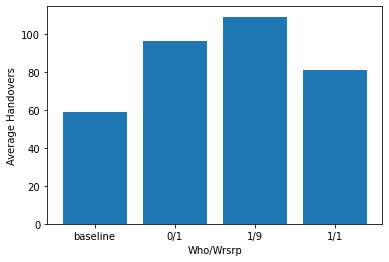

In [15]:
vals = [np.mean(hos), agent_0.mean_hos, agent_19.mean_hos,agent_1_1.mean_hos]
name = ['baseline', '0/1', '1/9', '1/1']
plt.bar(name, vals)
plt.ylabel('Average Handovers')
plt.xlabel('Who/Wrsrp')
plt.show()

In [16]:
agent_13 = Agent(6, NUM_BASE_STATIONS)

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 31)]              0         
_________________________________________________________________
dense_12 (Dense)             (None, 32)                1024      
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 32)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 64)                2112      
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 64)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 6)                 390       
Total params: 3,526
Trainable params: 3,526
Non-trainable params: 0
____________________________________________________

  0%|                                                                                         | 0/2000 [00:00<?, ?it/s]

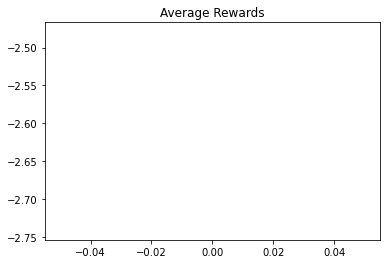

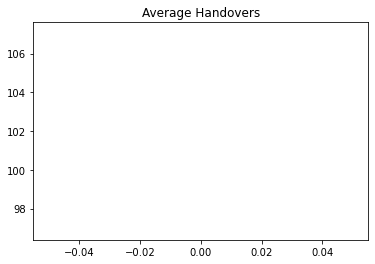

 50%|███████████████████████████████████████                                       | 1000/2000 [01:59<02:03,  8.09it/s]

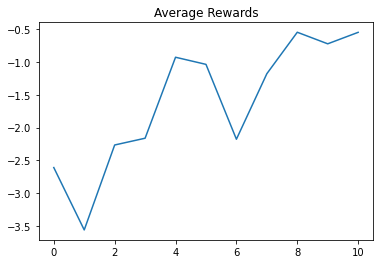

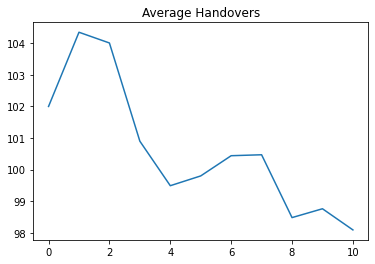

 50%|███████████████████████████████████████                                       | 1003/2000 [02:00<02:41,  6.19it/s]

Saved new weights for reward of -0.5442179545773026


 75%|██████████████████████████████████████████████████████████▌                   | 1502/2000 [03:01<01:01,  8.15it/s]

Saved new weights for reward of -0.06714456169683984


 85%|██████████████████████████████████████████████████████████████████▍           | 1702/2000 [03:25<00:36,  8.16it/s]

Saved new weights for reward of 2.357264249456774


 90%|██████████████████████████████████████████████████████████████████████▎       | 1802/2000 [03:38<00:25,  7.81it/s]

Saved new weights for reward of 4.196728055244611


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [04:02<00:00,  8.26it/s]


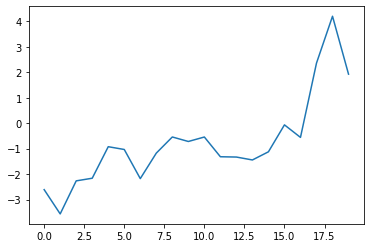

1.9235500297640673


In [17]:
agent = agent_13
Wrsrp = 1
Who = 1/3
last_r = []
rewards = []
hos = []
last_r_hos = []
r = 100
num_training_episode = 1
target_model_update = 100
max_reward = float('-inf')
path = 'agent_13.h5'

for episode in tqdm(range(2000)):
    src,dest = env.give_src_dest()
    src = (-3000,-2000)
    dest = (3000, 2000)
    route = env.compute_route(src, dest)
    state = route.popleft()
    depth = 3*NUM_BASE_STATIONS
    one_hot_cell = make_one_hot(env.sector_cells[src][0][0], depth)
    one_hot_direction = make_one_hot(state[-1]+1, 8)
    state = state[:-1]
    state.extend(one_hot_direction)
    state.extend(one_hot_cell) #Setting strongest cell as the initial serving cell (one_hot)
    done = 0
    total_reward = 0
    action = 0
    num_hos = 0
    
    while done==0:
        next_state, reward, done, change = agent.play_one_step(state, route, dest, Wrsrp, Who)
        total_reward+=reward
        state = next_state
        if change:
            num_hos+=1
    
    last_r_hos.append(num_hos)
    last_r.append(total_reward)
    
    if not episode%r:
        rewards.append(np.average(np.array(last_r)))
        hos.append(np.mean(last_r_hos))
        last_r = []
        last_r_hos = []
        
    if episode>50:
        agent.training_step(num_training_episode)
        
    if rewards[-1]>max_reward and episode>1000:
        max_reward = rewards[-1]
        agent.model.save_weights(path)
        print(f'Saved new weights for reward of {max_reward}')
            
    
    if episode%target_model_update==0:
        agent.target_model.set_weights(agent.model.get_weights())
    
    if episode%100==0:
        agent.epsilon*=0.99
        agent.epsilon = min(agent.epsilon, 0.05)
            
    if episode%1000==0:
        plt.plot(rewards)
        plt.title('Average Rewards')
        plt.show()
        plt.plot(hos)
        plt.title('Average Handovers')
        plt.show()
        
plt.plot(rewards)
plt.show()
print(rewards[-1])

In [18]:
agent.model.load_weights(path)
hos = []
rewards = []
agent.epsilon = 0
for episode in tqdm(range(100)):
    src,dest = env.give_src_dest()
    src = (-3000,-2000)
    dest = (3000, 2000)
    route = env.compute_route(src, dest)
    state = route.popleft()
    depth = 3*NUM_BASE_STATIONS
    one_hot_cell = make_one_hot(env.sector_cells[src][0][0], depth)
    one_hot_direction = make_one_hot(state[-1]+1, 8)
    state = state[:-1]
    state.extend(one_hot_direction)
    state.extend(one_hot_cell) #Setting strongest cell as the initial serving cell (one_hot)
    done = 0
    total_reward = 0
    num_hos = 0
    
    while done==0:
        next_state, reward, done, change = agent.play_one_step(state, route, dest, Wrsrp, Who)
        total_reward+=reward
        state = next_state
        if change:
            num_hos +=1
    rewards.append(total_reward)
    hos.append(num_hos)

agent.mean_reward = np.mean(rewards) 
agent.mean_hos = np.mean(hos)

print(agent.mean_reward)
print(agent.mean_hos)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.23it/s]

-0.9786308274137308
98.0


In [19]:
agent_23 = Agent(6, NUM_BASE_STATIONS)

Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 31)]              0         
_________________________________________________________________
dense_15 (Dense)             (None, 32)                1024      
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 32)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 64)                2112      
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 64)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 6)                 390       
Total params: 3,526
Trainable params: 3,526
Non-trainable params: 0
___________________________________________________

  0%|                                                                                         | 0/2000 [00:00<?, ?it/s]

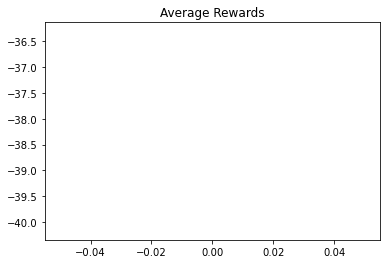

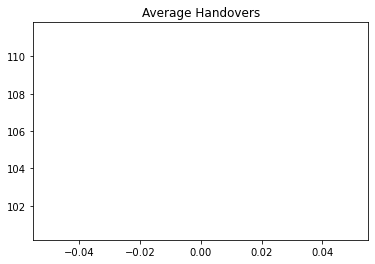

 50%|███████████████████████████████████████                                       | 1000/2000 [01:59<02:09,  7.73it/s]

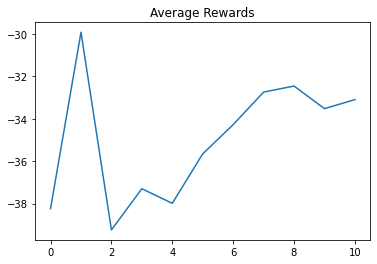

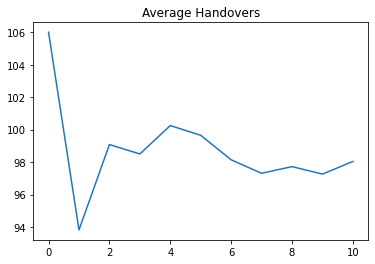

 50%|███████████████████████████████████████                                       | 1003/2000 [02:00<02:41,  6.16it/s]

Saved new weights for reward of -33.09437451236601


 60%|██████████████████████████████████████████████▉                               | 1202/2000 [02:25<01:40,  7.92it/s]

Saved new weights for reward of -26.835925907269843


 65%|██████████████████████████████████████████████████▊                           | 1302/2000 [02:37<01:25,  8.12it/s]

Saved new weights for reward of -24.060033815214553


 70%|██████████████████████████████████████████████████████▋                       | 1402/2000 [02:50<01:16,  7.83it/s]

Saved new weights for reward of -21.90457931531887


 75%|██████████████████████████████████████████████████████████▌                   | 1502/2000 [03:02<01:02,  8.02it/s]

Saved new weights for reward of -8.97955571428067


 85%|██████████████████████████████████████████████████████████████████▍           | 1702/2000 [03:27<00:37,  8.01it/s]

Saved new weights for reward of -3.0455496415089165


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [04:04<00:00,  8.18it/s]


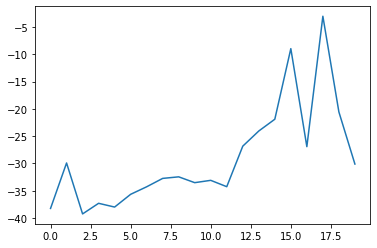

-30.112130839218445


In [20]:
agent = agent_23
Wrsrp = 1
Who = 2/3
last_r = []
rewards = []
hos = []
last_r_hos = []
r = 100
num_training_episode = 1
target_model_update = 100
max_reward = float('-inf')
path = 'agent_23.h5'

for episode in tqdm(range(2000)):
    src,dest = env.give_src_dest()
    src = (-3000,-2000)
    dest = (3000, 2000)
    route = env.compute_route(src, dest)
    state = route.popleft()
    depth = 3*NUM_BASE_STATIONS
    one_hot_cell = make_one_hot(env.sector_cells[src][0][0], depth)
    one_hot_direction = make_one_hot(state[-1]+1, 8)
    state = state[:-1]
    state.extend(one_hot_direction)
    state.extend(one_hot_cell) #Setting strongest cell as the initial serving cell (one_hot)
    done = 0
    total_reward = 0
    action = 0
    num_hos = 0
    
    while done==0:
        next_state, reward, done, change = agent.play_one_step(state, route, dest, Wrsrp, Who)
        total_reward+=reward
        state = next_state
        if change:
            num_hos+=1
    
    last_r_hos.append(num_hos)
    last_r.append(total_reward)
    
    if not episode%r:
        rewards.append(np.average(np.array(last_r)))
        hos.append(np.mean(last_r_hos))
        last_r = []
        last_r_hos = []
        
    if episode>50:
        agent.training_step(num_training_episode)
        
    if rewards[-1]>max_reward and episode>1000:
        max_reward = rewards[-1]
        agent.model.save_weights(path)
        print(f'Saved new weights for reward of {max_reward}')
            
    
    if episode%target_model_update==0:
        agent.target_model.set_weights(agent.model.get_weights())
    
    if episode%100==0:
        agent.epsilon*=0.99
        agent.epsilon = min(agent.epsilon, 0.05)
            
    if episode%1000==0:
        plt.plot(rewards)
        plt.title('Average Rewards')
        plt.show()
        plt.plot(hos)
        plt.title('Average Handovers')
        plt.show()
        
plt.plot(rewards)
plt.show()
print(rewards[-1])

In [21]:
agent.model.load_weights(path)
hos = []
rewards = []
agent.epsilon = 0
for episode in tqdm(range(100)):
    src,dest = env.give_src_dest()
    src = (-3000,-2000)
    dest = (3000, 2000)
    route = env.compute_route(src, dest)
    state = route.popleft()
    depth = 3*NUM_BASE_STATIONS
    one_hot_cell = make_one_hot(env.sector_cells[src][0][0], depth)
    one_hot_direction = make_one_hot(state[-1]+1, 8)
    state = state[:-1]
    state.extend(one_hot_direction)
    state.extend(one_hot_cell) #Setting strongest cell as the initial serving cell (one_hot)
    done = 0
    total_reward = 0
    num_hos = 0
    
    while done==0:
        next_state, reward, done, change = agent.play_one_step(state, route, dest, Wrsrp, Who)
        total_reward+=reward
        state = next_state
        if change:
            num_hos +=1
    rewards.append(total_reward)
    hos.append(num_hos)

agent.mean_reward = np.mean(rewards) 
agent.mean_hos = np.mean(hos)

print(agent.mean_reward)
print(agent.mean_hos)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.43it/s]

-2.871576291769788
79.0


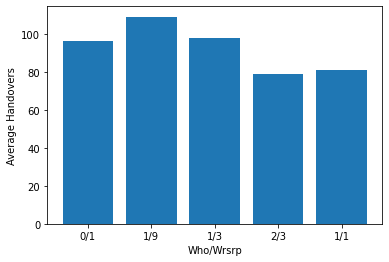

In [22]:
vals = [agent_0.mean_hos, agent_19.mean_hos, agent_13.mean_hos, agent_23.mean_hos,agent_1_1.mean_hos]
name = ['0/1', '1/9', '1/3', '2/3', '1/1']
plt.bar(name, vals)
plt.ylabel('Average Handovers')
plt.xlabel('Who/Wrsrp')
plt.show()